In [1]:
import os
import torch
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.listdir('./monkey_images_dataset/training/training/')
os.listdir('./monkey_images_dataset/validation/validation/')

['n2', 'n4', 'n6', 'n3', 'n7', 'n8', 'n9', 'n1', 'n0', 'n5']

In [3]:
train_path = './monkey_images_dataset/training/training/'
test_path = './monkey_images_dataset/validation/validation/'

In [4]:
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2037]

train_transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(torch.tensor(mean), torch.tensor(std))
                                ])

test_transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(torch.tensor(mean), torch.tensor(std))
                                ])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(root = test_path, transform=test_transform)

In [6]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=False)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('Labels', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels tensor([0, 0, 0, 0, 0, 0])


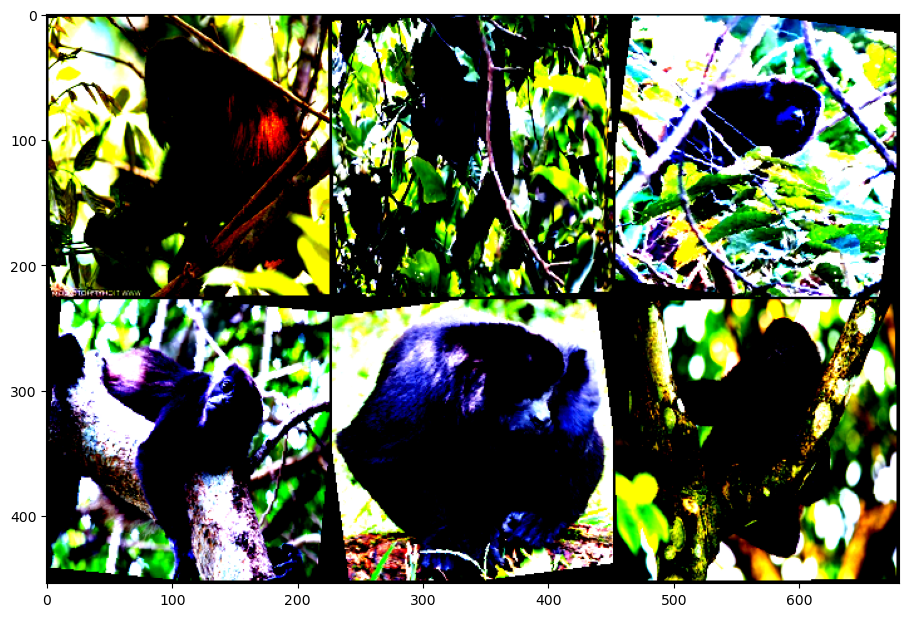

In [7]:
show_transformed_images(train_dataset)

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:

def evaluate_model_on_test_set(model, test_loader):
    best_accuracy = 0.0
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outpus = model(images)

            _, predicted = torch.max(outpus.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()
    epoch_acc = 100.0 * predicted_correctly_on_epoch / total
    print("     -Testing dataset. Got %d out of %d images correctly (%.3f%%) "
            % (predicted_correctly_on_epoch, total, epoch_acc))

    return epoch_acc


    # # Save the best model
    # if epoch_acc > best_accuracy:
    #     torch.save(model.state_dict(), 'best_checkpoint.model')
    #     best_accuracy=epoch_acc

In [11]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch' : epoch + 1,
        'model' : model.state_dict(),
        'best accuracy' : best_acc,
        'optimizer' : optimizer.state_dict(),
        'comments' : 'very cool model',
    }
    torch.save(state, "model_best_checkpoint.pth.tar")

In [12]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    best_acc = 0


    for epoch in range(n_epochs):
        print("Epoch number %d " % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print("     - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
            % (running_correct, total, epoch_acc, epoch_loss))

        test_dataset_acc = evaluate_model_on_test_set(model, test_loader)

        if (test_dataset_acc > best_acc):
            best_acc = test_dataset_acc
            save_checkpoint(model, epoch, optimizer, best_acc)

    print('Finished')
    return model


In [13]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained=True)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(),lr=0.01, momentum=0.9, weight_decay=0.003)

/home/sadam/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadam/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 150)

Epoch number 1 


/home/sadam/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


     - Training dataset. Got 759 out of 1097 images correctly (69.189%). Epoch loss: 0.964
     -Testing dataset. Got 258 out of 272 images correctly (94.853%) 
Epoch number 2 
     - Training dataset. Got 1071 out of 1097 images correctly (97.630%). Epoch loss: 0.080
     -Testing dataset. Got 260 out of 272 images correctly (95.588%) 
Epoch number 3 
     - Training dataset. Got 1090 out of 1097 images correctly (99.362%). Epoch loss: 0.026
     -Testing dataset. Got 270 out of 272 images correctly (99.265%) 
Epoch number 4 
     - Training dataset. Got 1093 out of 1097 images correctly (99.635%). Epoch loss: 0.014
     -Testing dataset. Got 270 out of 272 images correctly (99.265%) 
Epoch number 5 
     - Training dataset. Got 1096 out of 1097 images correctly (99.909%). Epoch loss: 0.008
     -Testing dataset. Got 269 out of 272 images correctly (98.897%) 
Epoch number 6 
     - Training dataset. Got 1097 out of 1097 images correctly (100.000%). Epoch loss: 0.006
     -Testing data

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
checkpoint = torch.load('model_best_checkpoint.pth.tar')

In [16]:
print(checkpoint['epoch'])
print(checkpoint['comments'])
print(checkpoint['best accuracy'])

6
very cool model
99.63235294117646


In [17]:
resnet18_model = models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet18_model.load_state_dict(checkpoint['model'])

torch.save(resnet18_model, 'best_model.pth')